In [11]:
import numpy as np
import torch as pt
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import collections as coll
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from matplotlib import cm
import gc
import numpy as np
import torch as pt
import torch
import torch.nn as nn
import torch

def print_gpu_memory():
    allocated_memory = torch.cuda.memory_allocated() / 1024 ** 3
    cached_memory = torch.cuda.memory_reserved() / 1024 ** 3
    print(f"Allocated GPU Memory: {allocated_memory:.2f} GB")
    print(f"Cached GPU Memory: {cached_memory:.2f} GB")

print_gpu_memory()
import time as TIME
import torch_tensorrt

from FHNCUDAlib import FHNCUDA
import numpy as np
import torch 

loaded_module = nn.Linear(10,10)
#loaded_module.load_state_dict()

#print(loaded_module.state_dict())
st=torch.load('network.0.pth')
#print(st)


pt.set_grad_enabled (False) 
numinputs=1
numoutputs=2
class Net(nn.Module):
    def __init__(self, numinputs, numoutputs, numlayers=4, H=10):
        super(Net, self).__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.utils.weight_norm(nn.Linear(numinputs, H), name='weight', dim=0).cuda())

        for _ in range(numlayers - 1):
            self.layers.append(nn.utils.weight_norm(nn.Linear(H, H), name='weight', dim=0).cuda())

        self.final_layer = nn.Linear(H, numoutputs).cuda()

        for layer in self.layers:
            layer.eval()
        self.final_layer.eval()

    def forward(self, x):
        for layer in self.layers:
            x = f.silu(layer(x))

        return self.final_layer(x)

    def load(self, od):
        for k, v in od.items():
            if k.startswith('_impl.layers'):
                layer_num = int(k.split('.')[2])
                layer = self.layers[layer_num]
                if k.endswith('linear.weight'):
                    layer.weight_v.data = v
                    layer.weight_v.requires_grad = False
                elif k.endswith('linear.weight_g'):
                    layer.weight_g.data = v
                    layer.weight_g.requires_grad = False
                elif k.endswith('linear.bias'):
                    layer.bias.data = v
                    layer.bias.requires_grad = False
            elif k == '_impl.final_layer.linear.weight':
                self.final_layer.weight.data = v
                self.final_layer.weight.requires_grad = False
            elif k == '_impl.final_layer.linear.bias':
                self.final_layer.bias.data = v
                self.final_layer.bias.requires_grad = False

    def __prepare_scriptable__(self):
        for layer in self.layers:
            for hook in layer._forward_pre_hooks.values():
                if hook.__module__ == "torch.nn.utils.weight_norm" and hook.__class__.__name__ == "WeightNorm":
                    torch.nn.utils.remove_weight_norm(layer)
        return self

import itertools



def Modelrun_s(x,M):
   
    gc.collect()
    torch.cuda.empty_cache()
    my2dspace = pt.tensor(x, requires_grad=False).float().cuda()
    M.eval()
    start_time = TIME.time()
    myOutput = M(my2dspace)
    torch.cuda.synchronize()
    reftime = TIME.time()- start_time
 
    myCPUOutput = myOutput.cpu()


    uu = myCPUOutput.numpy()

    #print('uu: ', uu.T[0])

    myCPUOutput.squeeze().detach().numpy()
    gc.collect()
    torch.cuda.empty_cache()
    return uu,reftime


def Modelrun(x, M, batch_size=10*20*10*200):

    my2dspace = x
    M.eval()
        
    num_samples = my2dspace.shape[0]
    print_gpu_memory()

    uu_list = []
   

    reftime =0
    for i in range(0, num_samples, batch_size):
        gc.collect()
        torch.cuda.empty_cache()
        batch_input =torch.tensor(my2dspace[i:i+batch_size], requires_grad=False).float().cuda() 
        start_time = TIME.time()
        batch_output = M(batch_input)
        torch.cuda.synchronize()
        reftime =reftime+ TIME.time() - start_time
        uu_list.append(batch_output.cpu().numpy())
        del batch_input
        del batch_output
  
 
    uu = np.concatenate(uu_list)
    
    print_gpu_memory()
    return uu, reftime




Allocated GPU Memory: 0.01 GB
Cached GPU Memory: 0.02 GB


In [3]:
def compileRT(modelTorch=Net(2,2)):
    gc.collect()
    torch.cuda.empty_cache()
    X=np.zeros((2,5))
    model = torch.jit.script(modelTorch).eval()  # torch module needs to be in eval (not training) mode



    trt_ts_module = torch_tensorrt.compile(modelTorch, inputs = [torch_tensorrt.Input(
            min_shape=(1*200,4),
            opt_shape=(1000*200,4),
        
            max_shape=(2000*200,4),
            dtype=torch.float32)],
        enabled_precisions = torch.float32, # Run with FP32
        workspace_size = 1 << 33
    )


    gc.collect()
    torch.cuda.empty_cache()
    return trt_ts_module



net =Net(4,2,10,10)

PATH=""
od=pt.load('network.0.pth')
net.load(od)
net=net.cuda()


model =  compileRT(net)
print("Done compiling")

print("Memory",print_gpu_memory())

Done compiling
Allocated GPU Memory: 0.00 GB
Cached GPU Memory: 0.00 GB
Memory None


Allocated GPU Memory: 0.01 GB
Cached GPU Memory: 0.02 GB
(2000, 3)
[[0.005 0.004 0.08 ]
 [0.005 0.004 0.083]
 [0.005 0.004 0.086]
 ...
 [0.905 0.232 0.101]
 [0.905 0.232 0.104]
 [0.905 0.232 0.107]]
4
Number of rows in the CSV file:  2000 200
-------------------------CUDA ----------------------------
4
Number of rows in the CSV file:  2000 200
Shape cudapred  (2000, 200)
cuda time [0.000118784, 0.030971104, 0.088647331]
Error Calculation
mean 0.0013891058950000002
max 0.659886


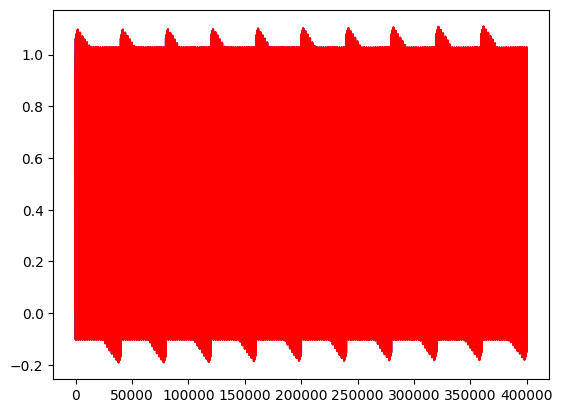

(200,)
[ 0.    0.25  0.5   0.75  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75
  3.    3.25  3.5   3.75  4.    4.25  4.5   4.75  5.    5.25  5.5   5.75
  6.    6.25  6.5   6.75  7.    7.25  7.5   7.75  8.    8.25  8.5   8.75
  9.    9.25  9.5   9.75 10.   10.25 10.5  10.75 11.   11.25 11.5  11.75
 12.   12.25 12.5  12.75 13.   13.25 13.5  13.75 14.   14.25 14.5  14.75
 15.   15.25 15.5  15.75 16.   16.25 16.5  16.75 17.   17.25 17.5  17.75
 18.   18.25 18.5  18.75 19.   19.25 19.5  19.75 20.   20.25 20.5  20.75
 21.   21.25 21.5  21.75 22.   22.25 22.5  22.75 23.   23.25 23.5  23.75
 24.   24.25 24.5  24.75 25.   25.25 25.5  25.75 26.   26.25 26.5  26.75
 27.   27.25 27.5  27.75 28.   28.25 28.5  28.75 29.   29.25 29.5  29.75
 30.   30.25 30.5  30.75 31.   31.25 31.5  31.75 32.   32.25 32.5  32.75
 33.   33.25 33.5  33.75 34.   34.25 34.5  34.75 35.   35.25 35.5  35.75
 36.   36.25 36.5  36.75 37.   37.25 37.5  37.75 38.   38.25 38.5  38.75
 39.   39.25 39.5  39.75 40.   40.25 40.5  4

In [7]:
gc.collect()
torch.cuda.empty_cache()

print_gpu_memory()
from itertools import product
gc.collect()
torch.cuda.empty_cache()
krange = [(0.08 + 0.03 * i * 0.1) for i in range(0, 10)]
vrange = [(0.004 + 0.1 * i * 0.12) for i in range(0, 20)]
urange = [(0.005 + 0.1 * i * 1) for i in range(0, 10)]


param_list = np.array(list(product(urange,vrange, krange )))




x0=np.array(param_list)

print(np.shape(x0))
print(x0)
dt,tt=0.01,50

rate=25


##Cuda ref
start_time = TIME.time()
u,v ,t,p=FHNCUDA.run(x0,tt,dt/1000,rate*1000)
reftime = TIME.time()- start_time
p=[i/1000 for i in p[0]]
u_ref=np.array(u).flatten()




print("-------------------------CUDA ----------------------------")

###Cuda run
start_time = TIME.time()
u,v ,t,p=FHNCUDA.run(x0,tt,dt,rate)
cudatime = TIME.time()- start_time

u_num=np.array(u).flatten()
print("Shape cudapred ",np.shape(u))

#print(np.unique(t))
p=[i/1000 for i in p[0]]
print("cuda time",p)
print("Error Calculation")
e=((u_ref-u_num)**2)**(1/2)
print("mean",np.mean(e))
m=np.max(e)
print("max",m)
plt.plot(u_ref[:],"b")
plt.plot(u_num[:],"r")

plt.show()

t=np.array(t).flatten()
print(np.shape(t))

print(t)
param_list = []

for u in urange:
    for v in vrange:
            for k in krange:
                for T in t:
                    param_list.append([T,u,v,k])





x0=np.array(param_list)
#print(x0)
#print(x0)
print_gpu_memory()

Allocated GPU Memory: 0.01 GB
Cached GPU Memory: 0.02 GB
-------------------------TORCH ----------------------------
(200,)


(400000, 2)
Shape netpred  (400000,)
net time 0.0194533109664917
Error Calculation
mean 0.06587990976162951
max 1.0970993458251954


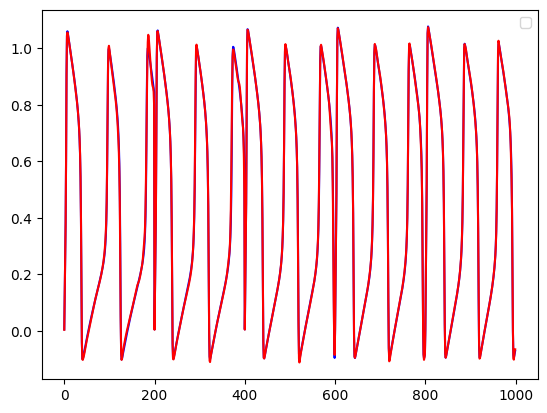

Allocated GPU Memory: 0.01 GB
Cached GPU Memory: 0.02 GB
-------------------------JIT ----------------------------
(200,)
Shape netpred  (400000,)
net time 0.03908078670501709
Error Calculation
mean 0.06587990976162951
max 1.0970993458251954


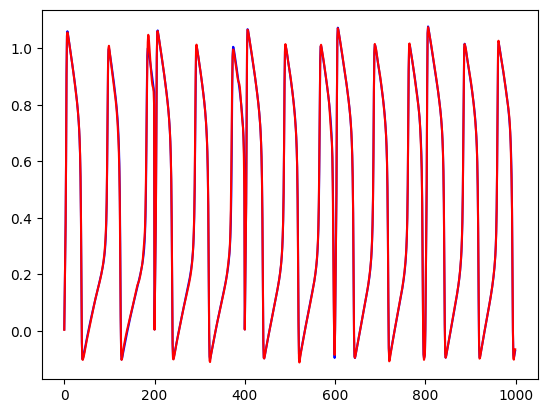

-----------------------------------------------------
Allocated GPU Memory: 0.01 GB
Cached GPU Memory: 0.02 GB
-------------------------TENSOR RT ----------------------------
(200,)
Shape netpred  (400000,)
net time 0.014296483993530274
Error Calculation
mean 0.06589617332214971
max 1.0978653847198487


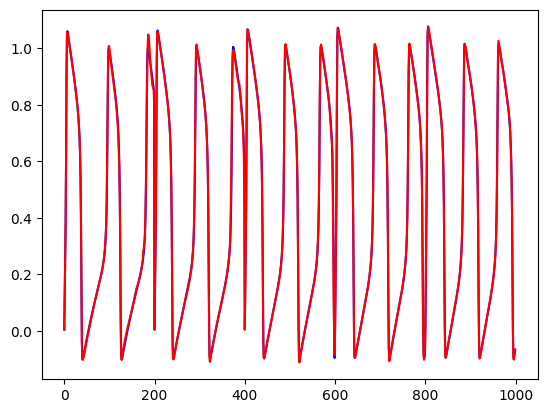

-----------------------------------------------------
Allocated GPU Memory: 0.01 GB
Cached GPU Memory: 0.02 GB


In [14]:
bs=40000


for _ in range (20):
    u,time=Modelrun_s(x0,M=net)


net_time=0
print_gpu_memory()
##PRED NETWORK TORCH
print("-------------------------TORCH ----------------------------")
print(np.shape(t))
start_time = TIME.time()
time=0
for _ in range (10):
    u,time=Modelrun_s(x0,M=net)
    net_time=net_time+time

print(np.shape(u))
u_net=u.T[0].flatten()

print("Shape netpred ",np.shape(u_net))
print("net time", net_time/10)
print("Error Calculation")
e=((u_ref-u_net)**2)**(1/2)
print("mean",np.mean(e))
m=np.max(e)
print("max",m)
i=[a for a in range(len(e)) if e[a]==m]


plt.plot(u_ref[0:1000],"b")
plt.plot(u_net[0:1000],"r")

plt.legend(loc="best")

plt.show()
("-----------------------------------------------------")


print_gpu_memory()
#PRED NETWORK JIT
print("-------------------------JIT ----------------------------")

print(np.shape(t))
time=0
for _ in range (10):
    u,time=Modelrun_s(x0,M=torch.jit.script(net).cuda())
    net_time=net_time+time
u_net=u.T[0].flatten()
print("Shape netpred ",np.shape(u_net))
print("net time", net_time/10)
print("Error Calculation")
e=((u_ref-u_net)**2)**(1/2)
print("mean",np.mean(e))
m=np.max(e)
print("max",m)
i=[a for a in range(len(e)) if e[a]==m]


plt.plot(u_ref[0:1000],"b")
plt.plot(u_net[0:1000],"r")
plt.show()
print("-----------------------------------------------------")

print_gpu_memory()


##PRED NETWORK RT
print("-------------------------TENSOR RT ----------------------------")
print(np.shape(t))
net_time=0
for _ in range (10):
    u,time=Modelrun_s(x0,M=model)
    net_time=net_time+time
u_net=u.T[0].flatten()
print("Shape netpred ",np.shape(u_net))
print("net time", net_time/10)
print("Error Calculation")
e=((u_ref-u_net)**2)**(1/2)
print("mean",np.mean(e))
m=np.max(e)
print("max",m)
i=[a for a in range(len(e)) if e[a]==m]


plt.plot(u_ref[0:1000],"b")
plt.plot(u_net[0:1000],"r")
plt.show()
print("-----------------------------------------------------")


gc.collect()
torch.cuda.empty_cache()

print_gpu_memory()

In [5]:
del batch_input

NameError: name 'batch_input' is not defined

KeyError: 'kernel'